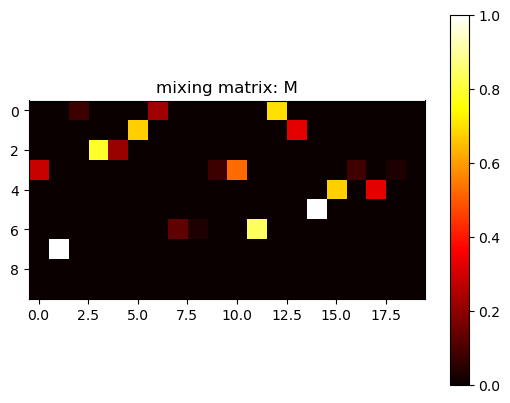

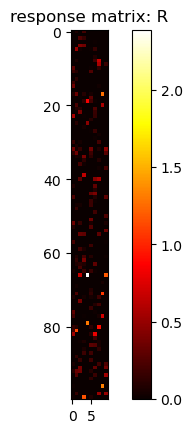

In [37]:
"""
This is an example for how to run factorization algorithms. 
"""

import numpy as np
import pandas as pd
import tensorflow as tf
import time
import os
import sys
import random
import matplotlib.pyplot as plt
# create a dataset for testing

n_samples = 2000
n_features = 20
n_factors = 10
n_response_patterns = 100


# feature matrix 
F = np.random.rand(n_features, n_samples)
# mixing matrix, sparse matrix
rows = n_factors
cols = n_features
M = np.zeros((rows, cols))

# Create a set of all column indices
cols_set = list(range(cols))

for i in range(rows):
    # Choose a random number of non-zero columns for this row
    nonzero_cols = min(random.randint(1, cols//4), len(cols_set))
    # Randomly choose which columns will be non-zero from remaining set
    cols_to_populate = random.sample(cols_set, nonzero_cols)
    # Generate random probabilities that sum up to 1
    probs = np.random.dirichlet(np.ones(nonzero_cols), size=1)[0]
    # Populate the chosen columns with these probabilities
    for col_index, prob in zip(cols_to_populate, probs):
        M[i][col_index] = prob
    # Remove selected columns from the set
    for col in cols_to_populate:
        cols_set.remove(col)

# Display the matrix as an image
plt.imshow(M, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('mixing matrix: M')
plt.show()


# response matrix, for each factor, there is a pattern of response associated with it so there should be n_factor response patterns, each pattern is a vector of length n_response_pattern
# note that we expect the response matrix to be sparse 
R = np.zeros((n_factors, n_response_patterns))

for i in range(n_factors):
    # decide the number of non-zero responses for this factor, here we randomly decide it to be between 1 and half the length of the response pattern
    non_zero_responses = random.randint(1, n_response_patterns//3)
    # choose which responses will be non-zero
    responses_to_populate = random.sample(range(n_response_patterns), non_zero_responses)
    # generate random probabilities that sum up to 5 for the non-zero responses

    probs = np.random.dirichlet(np.ones(non_zero_responses), size=1)[0]
    # populate the chosen responses with these probabilities
    for response_index, prob in zip(responses_to_populate, probs):
        R[i][response_index] = 5*prob
R = R.T

# Display the response matrix as an image
plt.imshow(R, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('response matrix: R')
plt.show()

X_true = np.dot(R, np.dot(M,F))


# run NMF


# run feature_based matrix factorization

# run network-based matrix factorization


In [4]:
"""
Given two matrices, we want to match the the columns from one to another by computing correlation between columns
"""

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import sys
import time
from scipy import stats
def match_columns(A, B, reps = 4):
    col_A = A.shape[1]
    col_B = B.shape[1]
    # compute the correlation matrix
    corr = np.zeros((col_A, col_B))

    for i in range(col_A):
        for j in range(col_B):
            corr[i][j] = np.corrcoef(A[:,i], B[:,j])[0][1]
            # take the absolute value of correlation
            corr[i][j] = abs(corr[i][j])
    # find the best match for each column in A, if a column in B is matched, it cannot be matched again
    # permute columns of A for rep times and find the best match to get the consensus, avoiding effect of processing orders
    match = np.zeros((reps, col_A))
    for rep in range(reps):
        corr_copy = corr.copy()
        permutate_order = np.random.permutation(col_A)
        for k in permutate_order:
            match[rep, k] = np.argmax(corr_copy[k])
            # set the correlation to -1 so that it won't be matched again
            corr_copy[:,int(match[rep, k])] = -2

    # take the mode of the match result
    match_result = stats.mode(match, axis = 0)[0][0]
    match_result = match_result.astype(int)
    print(match_result)
    # document the max correlation for each column in A
    max_corr = np.zeros(col_A)
    for i in range(col_A):
        max_corr[i] = corr[i][match_result[i]]
    return match_result, max_corr

# test
def main():
    A = np.random.rand(4, 5)
    # duplicate A's first column 
    A = np.append(A, A[:,0].reshape(4,1), axis = 1)
    # B is permutation of A along the column dimension 
    B = A[:, np.random.permutation(5)]
    # append the first column of A to the end of B
    B = np.append(B, A[:,0].reshape(4,1), axis = 1)
    match = match_columns(A, B, reps = 10)
    print("Expecting the first and last column of A to be matched with two columns of B, and others to be matched with one column of B")
    print(match)

if __name__ == '__main__':
    main()






[4 3 0 1 2 5]
Expecting the first and last column of A to be matched with two columns of B, and others to be matched with one column of B
(array([4, 3, 0, 1, 2, 5]), array([1., 1., 1., 1., 1., 1.]))


/var/folders/5s/mwy_qtwx1g9ggvbfvg1x1d5m0000gn/T/ipykernel_27187/4012565944.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  match_result = stats.mode(match, axis = 0)[0][0]


In [10]:
import numpy as np
from scipy.optimize import minimize

# Helper functions to vectorize and devectorize matrices
def vec(matrix):
    return matrix.flatten()

def devec(vector, shape):
    return vector.reshape(shape)


def matrix_factorization(X,F, k:int, max_iter:int=1000, tol:float=1e-4, lambda_1:float = 0.5, residual:bool = False):
    """
    X: result matrix, p by n  
    F: feature matrix, f by n
    k: number of factors
    max_iter: maximum number of iterations
    tol: tolerance for convergence
    lambda: regularization parameter, higher lambda means stronger encouragement for orthogonality
    """
    # Initialize W and H
    p, n = X.shape
    f = F.shape[0]
    # check if n matches second dimension of F, if not print out error message
    assert n == F.shape[1], "second dimension of X and F must match"

    W_shape = (p, k)
    H_shape = (k, f)

    W_init = np.random.rand(*W_shape)
    H_init = np.random.rand(*H_shape)

    # Objective function to minimize
    def objective(params, X, F, W_shape, H_shape):
        W_vec, H_vec = np.split(params, [np.prod(W_shape)])
        W = devec(W_vec, W_shape)
        H = devec(H_vec, H_shape)
        
        # Reconstruction error term
        reconstruction_error = np.linalg.norm(X - W @ H @ F)
        
        # Orthogonality encouraging term
        # Higher lambda means stronger encouragement for orthogonality
        W_orthogonality = np.sum(np.abs(W.T @ W - np.eye(W_shape[1])))
        H_orthogonality = np.sum(np.abs(H @ H.T - np.eye(H_shape[0])))

        return reconstruction_error + lambda_1 * (W_orthogonality + H_orthogonality)
    

    # Run the optimization
    result = minimize(
        objective,
        x0=vec(np.concatenate((W_init, H_init), axis=None)),
        args=(X, F, W_shape, H_shape),
        method='CG', 
        options={'maxiter': max_iter, 'disp': False, 'gtol': tol}
        )
    # Extract the optimized W and H
    W_opt, H_opt = np.split(result.x, [np.prod(W_shape)])
    W_opt = devec(W_opt, W_shape)
    H_opt = devec(H_opt, H_shape)



    if residual:
        # compute the residual error 
        residual_error = np.linalg.norm(X - W_opt @ H_opt @ F)
        # divide the residual error by the norm of X to get the relative residual error
        relative_residual_error = residual_error / np.linalg.norm(X - np.mean(X))
        return W_opt, H_opt, relative_residual_error
    else:
        return W_opt, H_opt


[6 6 7 5 0 9 8 8 2 2]
(array([6, 6, 7, 5, 0, 9, 8, 8, 2, 2]), array([0.19315702, 0.45801339, 0.63784036, 0.35380169, 0.46534743,
       0.47580209, 0.27112753, 0.28484295,        nan,        nan])) 0.40950184319260724


/Users/bowen/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/bowen/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/5s/mwy_qtwx1g9ggvbfvg1x1d5m0000gn/T/ipykernel_27187/4012565944.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  match_result = stats.mode(match, axis = 0)[0][0]


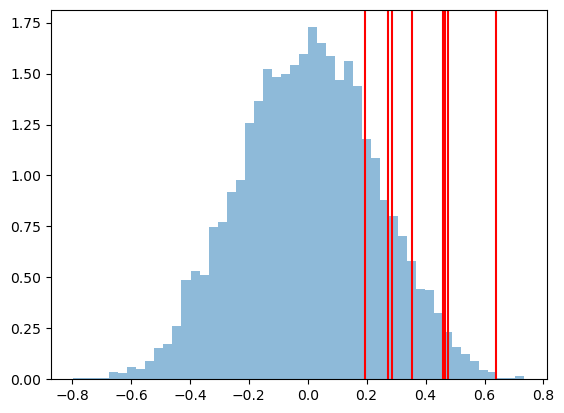

In [39]:
W_hat, H_hat, error = matrix_factorization(X_true, F, k = n_factors, max_iter = 20, tol = 1e-3, lambda_1 = 0.05, residual = True)
match_result = match_columns(M.T, H_hat.T, reps = 50)
print(match_result, error)
# simulate a null distribution by creating a random matrix with statsitics matching H_hat for correlation 
# simulate a null distribution by creating a random matrix with statsitics matching H_hat for correlation 
HT_shape = H_hat.T.shape
null_corr =[]
for i in range(100):
    H_hat_mean = np.mean(H_hat.T, axis = 0)
    H_hat_std = np.std(H_hat.T, axis = 0)
    H_hat_null = np.random.normal(H_hat_mean, H_hat_std, HT_shape)
    coefs = np.corrcoef(M,H_hat_null.T)[H_hat_null.shape[1]:, :H_hat_null.shape[1]].flatten()
    null_corr += list(coefs)
# plot 
matched_result_coefs = match_result[1]
plt.hist(null_corr, bins = 50, density = True, alpha = 0.5)
for x in matched_result_coefs:
    plt.axvline(x, color = 'red')
plt.show()





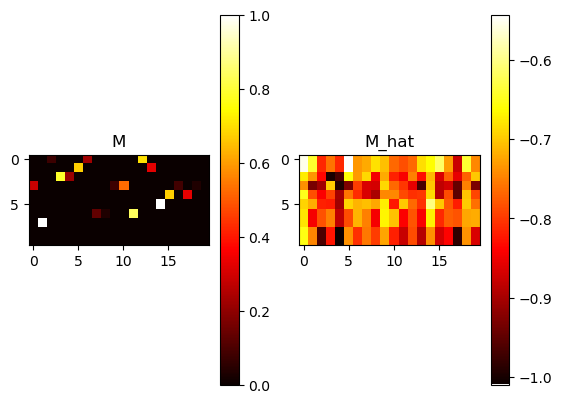

In [41]:
# Display the M and H matrices as images side by side for comparison
plt.subplot(1,2,1)
plt.imshow(M, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('M')
plt.subplot(1,2,2)
plt.imshow(H_hat[match_result[0]], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('M_hat')
plt.show()

In [123]:
def matrix_factorization_sgd_vectorized(X, F, k:int, max_iter:int=50, tol:float=1e-4, lambda_1:float=0.5, learning_rate:float=0.001):
    """
    X: result matrix, p by n  
    F: feature matrix, f by n
    k: number of factors
    max_iter: maximum number of iterations
    tol: tolerance for convergence
    lambda: regularization parameter, higher lambda means stronger encouragement for orthogonality
    """
    # Initialize W and H
    p, n = X.shape
    f = F.shape[0]
    assert n == F.shape[1], "second dimension of X and F must match"

    W = np.random.rand(p, k)
    H = np.random.rand(k, f)
    error_list = []
    # Iterate over the dataset
    for it in range(max_iter):
        
        for i in range(n):
            xi = X[:, i]
            Fi = F[:, i][:, np.newaxis]

            # Vectorized computation of the gradient and update of W and H
            error = xi[:, np.newaxis] - W @ (H @ Fi)
            W_grad = -2 * error @ (H @ Fi).T + lambda_1 * W
            H_grad = -2 * W.T @ error @ Fi.T + lambda_1 * H

            W -= learning_rate * W_grad
            H -= learning_rate * H_grad

            # Project W, H back into the feasible (non-negative) region
            W = np.maximum(W, 0)
            H = np.maximum(H, 0)

        # Check for convergence
        reconstruction_error = np.linalg.norm(X - W @ H @ F)
        if reconstruction_error < tol:
            print(f'Converged after {it} iterations')
            break
        # record the loss every 10 epochs
        if it % 5 == 0:
            error_list.append(reconstruction_error)
    print("reach max_iter")
    # plot the loss 
    plt.plot(error_list[1:])
    plt.xlabel("After 50 epoch")
    plt.ylabel("loss")
    plt.show()
    return W, H


In [124]:
W_hat, H_hat = matrix_factorization(X_true, F, k = n_factors, max_iter = 100, tol = 1e-3, lambda_1 = 0.05)

         Current function value: 34.000955
         Iterations: 100
         Function evaluations: 107712
         Gradient evaluations: 192


In [120]:

match_result = match_columns(M.T, H_hat.T, reps = 50)
print(match_result)


[1 4 0 3 3]
(array([1, 4, 0, 3, 3]), array([0.21269225, 0.98942777, 0.59374569, 0.63327043, 0.5336719 ]))


/var/folders/5s/mwy_qtwx1g9ggvbfvg1x1d5m0000gn/T/ipykernel_13740/4012565944.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  match_result = stats.mode(match, axis = 0)[0][0]


In [121]:
match_result

(array([1, 4, 0, 3, 3]),
 array([0.21269225, 0.98942777, 0.59374569, 0.63327043, 0.5336719 ]))

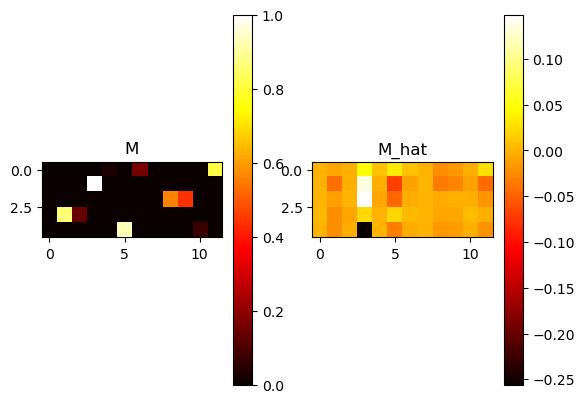

In [122]:
# Display the M and H matrices as images side by side for comparison
plt.subplot(1,2,1)
plt.imshow(M, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('M')
plt.subplot(1,2,2)
plt.imshow(-H_hat, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('M_hat')
plt.show()

In [118]:
import torch
from torch import nn

class NMFFC(nn.Module):
    def __init__(self, input_dim, output_dim, n_factors):
        super(NMFFC, self).__init__()

        # The weight matrix serves as W in the factorization
        self.fc = nn.Linear(input_dim, n_factors, bias=False)

        # This layer serves as H in the factorization
        self.decoder = nn.Linear(n_factors, output_dim, bias=False)

        # Enforce non-negativity with ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        encoded = self.fc(x)
        decoded = self.decoder(encoded)
        return decoded



In [50]:
# Convert data to tensors
X_tensor = torch.from_numpy(X_true).float()

# Create dataset and data loader
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=10) # Adjust batch size as needed

residual 0.006384859669634065


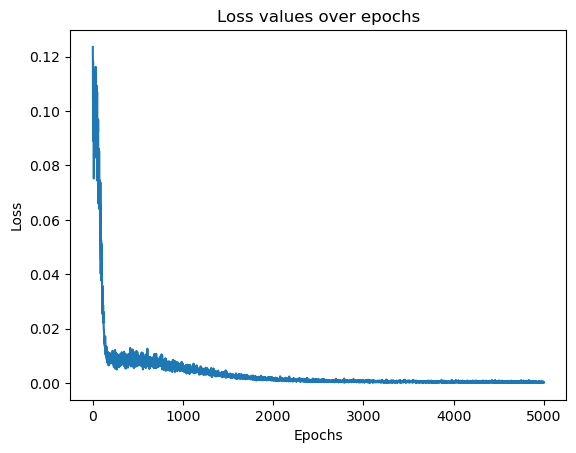

In [147]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
epochs = 5000
# One-hot encode samples
X_one_hot = np.eye(n_samples)
# Convert data to tensors
X_tensor = torch.from_numpy(X_one_hot).float()
Y_tensor = torch.from_numpy(X_true.T).float()  # Transposed to match the samples
# Create dataset and data loader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=10,  shuffle=True)  # Adjust batch size as needed

# Apply NN-based NMF
model_nn = NMFFC(n_samples, n_response_patterns, n_factors)
optimizer = torch.optim.SGD(model_nn.parameters(), lr=0.001)
# set a cycle scheduler to adjust the learning rate
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(dataloader), epochs=epochs)
# Define the loss function
loss_fn = nn.MSELoss()

# Prepare to store loss for plotting
loss_values = []

# Training loop
for epoch in range(epochs):
    for _, (X_batch, Y_batch) in enumerate(dataloader):
        # Forward pass: Compute predicted y by passing x to the model
        Y_pred = model_nn(X_batch)

        # Compute and print loss
        loss = loss_fn(Y_pred, Y_batch)
        # print(f'Epoch {epoch}, Loss: {loss.item()}')
        
        # Store loss

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()

        # add non-negativity constraint
        for param in model_nn.parameters():
             param.data = torch.clamp(param.data, min=0)

        optimizer.step()
    scheduler.step()
    loss_values.append(loss.item())

# Compute residual
Y_pred = model_nn(X_tensor).detach().numpy()
residual_nn = np.square(X_true - Y_pred.T).sum()
print(f'residual {get_residual_ratio(X_true, Y_pred.T)}')
# Plot loss
plt.plot(loss_values)
plt.title('Loss values over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


(array([6861., 3405., 3387., 2786., 1847., 1047.,  451.,  159.,   48.,
           9.]),
 array([-1.17710442e-05,  3.77046205e-02,  7.54210129e-02,  1.13137402e-01,
         1.50853798e-01,  1.88570186e-01,  2.26286575e-01,  2.64002979e-01,
         3.01719368e-01,  3.39435756e-01,  3.77152145e-01]),
 <BarContainer object of 10 artists>)

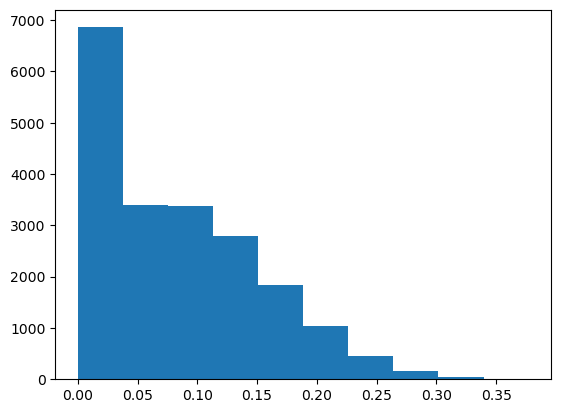

In [148]:
plt.hist(model_nn.fc.weight.data.flatten())

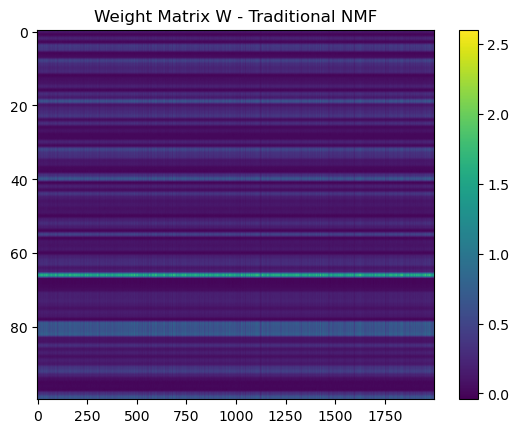

In [128]:
# Visualize weight matrix W
plt.imshow(Y_pred.T, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Weight Matrix W - Traditional NMF')
plt.show()

In [119]:
# Apply NN-based NMF
model_nn = NMFFC(n_samples, n_response_patterns, n_factors)

In [120]:
# set fc.wirghts to be H
model_nn.fc.weight = nn.Parameter(torch.from_numpy(H).float())
model_nn.decoder.weight = nn.Parameter(torch.from_numpy(W).float())

In [121]:
# Compute residual
Y_pred = model_nn(X_tensor).detach().numpy()
residual_nn = np.square(X_true - Y_pred.T).sum()



In [122]:
residual_nn

0.13076129976402218

/Users/bowen/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


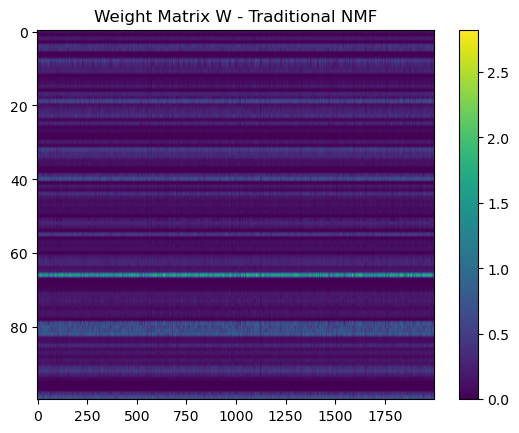

In [116]:
# compare the result to non negative matrix factorization
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt


# Apply traditional NMF
model_nmf = NMF(n_components=n_factors, init='random', random_state=0)
W = model_nmf.fit_transform(X_true)
H = model_nmf.components_

# Compute residual
X_pred = np.dot(W, H)
residual_nmf = np.square(X_true - X_pred).sum()

# Visualize weight matrix W
plt.imshow(X_true, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Weight Matrix W - Traditional NMF')
plt.show()


In [144]:
# Print residuals
print(f"Residual for traditional NMF: {get_residual_ratio(X_true,X_pred )}")
print(f"Residual for NN-based NMF: {get_residual_ratio(X_true,Y_pred.T )}")

Residual for traditional NMF: 1.0613076144319387e-05
Residual for NN-based NMF: 3.7677032585564372e-06


In [132]:
def get_residual_ratio(X_true, X_pred):
    return np.square(X_true - X_pred).sum() / np.square(X_true - np.mean(X_true)).sum()
